In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import warnings
from scipy.stats import norm

import sys
sys.path.append('../')
import src as src

In [1]:
class BaseModel:
    
    '''
    Base class for models
    '''
    
    def __init__(self):
        pass
    
    def score(self, Y):
        
        '''
        Returns the log-likelihood of an observation sequence
        '''
        
        score = np.log(self.pdf(Y)).sum()
        return score


class NormalModel(BaseModel):
    
    '''
    i.i.d. normal distribution model
    '''
    
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.sigma = sigma
    
    @property
    def loc(self):
        return self.mu
    
    @property
    def scale(self):
        return self.sigma
    
        
    def fit(self, Y, weights=None):
        
        '''
        Fits the model parameters to an observation sequence.
        weights are optional.
        '''
        
        # prepare
        Y = np.array(Y)
        if weights is None:
            weights = np.ones(Y.shape)
        else:
            weights = np.array(weights)
        
        # estimate mean
        mean = np.average(Y, weights=weights)
        
        # estimate variance
        errors = (Y-mean)**2
        variance = np.average(errors, weights=weights)
        
        # update
        self.mu = mean
        self.sigma = np.sqrt(variance)
        
    def pdf(self, Y):
        
        '''
        Returns the likelihood of each observation in an observation sequence.
        '''
        
        Y = np.array(Y)
        pdf = norm(loc=self.mu, scale=self.sigma).pdf(Y)
        return pdf


In [2]:
import numpy as np
from scipy.stats import entropy

class MarkovChain:
    
    '''
    A MarkovChain
    '''
    
    def __init__(self, transition_matrix=None, state_vector=None):
        self.transition_matrix = transition_matrix
        self.state_vector = state_vector

    @property
    def transition_matrix(self):
        
        '''
        The Markov state transition probability matrix.
        Needs to be square.
        '''
        
        return self._transition_matrix
        
    @transition_matrix.setter
    def transition_matrix(self, transition_matrix):
        if transition_matrix is not None:        
            transition_matrix = np.array(transition_matrix)
            assert transition_matrix.shape[0] == transition_matrix.shape[1], \
                'transition matrix needs to be square'
            assert all(transition_matrix.sum(axis=1) == 1), \
                'transition matrix rows need to sum to one'
            if hasattr(self, 'state_vector'):
                assert transition_matrix.shape[0] == self.state_vector.shape[1], \
                    'state vector dimension mismatch'
            self._transition_matrix = transition_matrix
        else:
            self._transition_matrix = None
        
    
    @property
    def state_vector(self):
        
        '''
        The current state vector.
        '''
        
        return self._state_vector
    
    @state_vector.setter
    def state_vector(self, state_vector):
        if state_vector is not None:
            state_vector = np.array(state_vector).reshape(1,-1)
            assert state_vector.sum(axis=1) == 1, \
                'state vector needs to sum to one'
            assert (state_vector>=0).all() and (state_vector<=1).all(), \
                'probabilites need to be bounded between zero and one'
            if hasattr(self, 'transition_matrix'):
                assert state_vector.shape[1] == self.transition_matrix.shape[0], \
                    'transition matrix dimension mismatch'
            self._state_vector = state_vector
        else:
            self._state_vector = None
    

    def steady_state(self, set_state=False):
        
        '''
        Returns the steady state probabilities of the Markov chain.
        If set_state=True, MarkovChain object is modified in place.
        '''
        
        dim = np.array(self.transition_matrix).shape[0]
        q = np.c_[(self.transition_matrix-np.eye(dim)),np.ones(dim)]
        QTQ = np.dot(q, q.T)
        steady_state = np.linalg.solve(QTQ,np.ones(dim))
        if set_state:
            self.state_vector = steady_state
        else:
            return steady_state
        
        
    @property
    def expected_durations(self):
        
        '''
        Returns the expected state durations of the MarkovChain object.
        '''
        
        expected_durations = (np.ones(self.n_states)-np.diag(self.transition_matrix))**-1
        return expected_durations
    
    
    @property
    def n_states(self):
        
        '''
        Returns the number of states of the MarkovChain object.
        '''
        
        return self.state_vector.shape[1]


    def iterate(self, steps=1, set_state=False):
        
        '''
        Iterates the MarkovChain object in place.
        steps needs to be a positive integer.
        (negative steps work, but tend to break before the initial state)
        If set_state=True, MarkovChain object is modified in place.
        '''
        
        new_state = np.dot(self.state_vector, np.linalg.matrix_power(self.transition_matrix, steps))
        
        # ensure total probability is 1
        if new_state.sum() != 1:
            new_state = new_state.round(8)/new_state.round(8).sum()
            warnings.warn('Transition matrix rounded to 8 decimal places')
        
        if set_state:
            self.state_vector = new_state
        else:
            return new_state
        
        
    def forecast(self, horizons=[1]):
        
        '''
        Returns forecasted state probabilities for a set of horizons.
        horizons needs to be an iterable.
        '''
        
        horizons_states = np.array([]).reshape(0, self.n_states)
        for horizon in horizons:
            pi_ = np.dot(self.state_vector, np.linalg.matrix_power(self.transition_matrix, horizon))
            horizons_states = np.concatenate([horizons_states, pi_.reshape(1, self.n_states)], axis=0)
        return horizons_states
    

    def rvs(self, t_steps=0, random_state=1):
        
        '''
        Draws a random sample sequence from the MarkovChain object.
        t_steps is the number of time steps forward to be drawn.
        If t_steps is zero, only the current state is drawn.
        '''
        
        sample = np.random.choice(self.n_states, size=1, p=self.state_vector.squeeze())
        for t in range(1, t_steps+1):
            sample = np.concatenate([sample, \
                                     np.random.choice(self.n_states, size=1, p=self.transition_matrix[sample[-1]])])
        return sample
    
    
    def entropy(self, horizons=None):
        
        '''
        Calculate Shannon's entropy of the n state probabilities based on logarithms with base n.
        '''
        
        if horizons is None:
            state_entropy = entropy(self.state_vector.squeeze(), base=self.n_states)
        
        else:
            horizon_states = self.forecast(horizons)
            state_entropy = []
            for horizon in horizon_states:
                state_entropy += [entropy(horizon.squeeze(), base=self.n_states)]
            
        return np.array(state_entropy)
    

In [31]:
mc = src.MarkovChain(np.array([[0.99,0.01],[0.2,0.8]]),np.array([0,1]))
mc.iterate(1, set_state=True)
mc.state_vector
mc.transition_matrix
mc.forecast([5,1,7,123,45,0])

array([[0.72086909, 0.27913091],
       [0.358     , 0.642     ],
       [0.8078944 , 0.1921056 ],
       [0.95238095, 0.04761905],
       [0.95236235, 0.04763765],
       [0.2       , 0.8       ]])

In [33]:
mc.iterate(2)

In [34]:
mc.steady_state()

array([0.95238095, 0.04761905])

In [36]:
mc.expected_durations

array([100.,   5.])

In [5]:
mc.entropy()

array(0.72192809)

## HMM Class 

In [12]:
class HiddenMarkovModel(MixtureModel, MarkovChain):
    
    '''
    Hidden Markov Model class
    '''
    
    def __init__(self, emission_models=None, transition_matrix=None, state_vector=None):#, start_probas=None, switch_var=True, switch_const=True, k=None):
        self.transition_matrix = transition_matrix
        self.state_vector = state_vector
        self.emission_models = emission_models
        self.is_fitted = False
        
        
    @property
    def emission_models(self):
        
        '''
        A tuple of emission models associated with the Markov states.
        '''
        
        return self._emission_models
    
    @emission_models.setter
    def emission_models(self, emission_models):
        if emission_models is not None:
            emission_models = tuple(emission_models)
            if self.transition_matrix is not None:
                assert len(emission_models) == self.transition_matrix.shape[0], \
                    'number of emission models inconsitent'
            elif self.state_vector is not None:
                assert len(emission_models) == self.state_vector.shape[1], \
                    'number of emission models inconsitent'
            self._emission_models = emission_models
            
        else:
            self._emission_models = None
            
            
    @property
    def components(self):
        
        '''
        The mixture distribution components.
        '''
        
        weights = self.state_vector
        components = [(component, weight) for (component, weight) in zip(self.emission_models, weights)]
        return components
        
    
    
    def fit(self, Y, method):
        self.is_fitted = True
    
    
    def _estimate_baum_welch(self, Y, max_iter=100, threshold=1e-6, return_fit=False):
        
        '''
        Performs parameter estimation with the Baum-Welch algorithm.
        Returns a fitted model.
        Returns the the fitted model and parameters of the estimation if return_fit=True.
        '''
        
        # initialise
        Y = np.array(Y)
        A_, pi_, models_ = self._initialise_baum_welch()
        self._check_baum_welch_inputs(A_, pi_, models_)
        score_, B_ = self._score(Y, models_, pi_)
        
        # store
        iteration = 0
        scores = {iteration: score_}
        
        while iteration < max_iter:
            iteration += 1
            Alpha, Gamma, Xi = self._do_e_step(Y, A_, B_, pi_)          
            A_, models_, pi_ = self._do_m_step(Y, models_, Gamma, Xi)
            score_, B_ = self._score(Y, models_, Gamma)
            scores[iteration] = score_
            
            if abs(scores[iteration]-scores[iteration-1]) < threshold:
                converged = True
                break
        else:
            converged = False
            warnings.warn('maximum number of iterations reached')
                
        self._update_attributes(A_, models_, pi_)
        
        if return_fit:
            fit = {'converged': converged,
                   'iterations': iteration,
                   'scores': scores,
                   'pdfs': B_,
                   'smoothened_probabilities': Gamma,
                   'filtered_probabilities': Alpha}
            
            return self, fit
        else:
            return self
    
    
    def _initialise_baum_welch(self):
        
        '''
        Returns initial values for the Baum-Welch algorithm.
        '''
        
        assert self.emission_models is not None, \
            'emission models not specified'
            
        if self.state_vector is None:
            self.steady_state(set_state=True)
        if self.transition_matrix is None:
            self.transition_matrix = np.full([self.n_states, self.n_states], 1/self.n_states)
        
        A = self.transition_matrix
        models = self.emission_models
        pi = self.state_vector
        return A, pi, models
    
    
    def _check_baum_welch_inputs(self, A, pi, models):
        
        '''
        Checks the dimension match of algorithm inputs.
        '''

        assert len(models) == A.shape[0] == A.shape[1] == pi.shape[1], \
            'dimension mismatch'
    
    
    def _score(self, Y, emission_models, Gamma):
        
        '''
        Returns the overall model score and component model pdf values for each observation.
        '''
        
        B = self._evaluate_emission_models(Y, emission_models)
        score = np.log((B * Gamma).sum(axis=1)).sum(axis=0)
        return score, B
    
    
    def _evaluate_emission_models(self, Y, emission_models):
        
        '''
        Returns component model pdf values for each observation.
        '''
        
        B = np.concatenate([model.pdf(Y).reshape(-1, 1) for model in emission_models], axis=1)
        return B
    
    
    def _do_e_step(self, Y, A, B, pi):
        
        '''
        Performs all steps of the E-step and returns temporary variables.
        All data state probabilities are updated based on the existing component models.
        '''
        
        Alpha, C = self._forward_pass(A, B, pi)
        Beta = self._backward_pass(A, B, pi, C)
        Gamma = self._emission_odds(Alpha, Beta)
        Xi = self._transition_odds(A, B, Alpha, Beta)
        return Alpha, Gamma, Xi
    
    
    def _forward_pass(self, A, B, pi):
        
        '''
        Returns filtered probabilities of the data together with each scaling factor.
        '''
        
        # initialise forward pass with first observation
        alpha_0 = pi * B[0]
        c_0 = 1/alpha_0.sum()
        
        # save values & scaling factor
        Alpha = alpha_0*c_0
        C = [c_0]
        
        # iterate
        for b_t in B[1:]:
            # calculate
            alpha_t = (b_t * Alpha[-1] @ A).reshape(1, -1)
            c_t = 1/alpha_t.sum()
            
            # save
            Alpha = np.concatenate((Alpha, alpha_t*c_t), axis=0)
            C += [c_t]
            
        C = np.array(C).reshape(-1, 1)
        return Alpha, C

    
    def _backward_pass(self, A, B, pi, C):
        
        '''
        Returns smoothened probabilities of the data.
        '''
        
        # initialise backward pass as one
        beta_T = np.ones(pi.shape)
        
        # save values & scaling factor
        Beta = beta_T*C[-1]
        
        # iterate
        for b_t, c_t in zip(B[:0:-1],C[len(C)-2::-1]):
            # calculate
            beta_t = (b_t * Beta[0] @ A.T).reshape(1, -1)
            
            # save
            Beta = np.concatenate((beta_t*c_t, Beta), axis=0)
            
        return Beta
    
    
    def _emission_odds(self, Alpha, Beta):
        
        '''
        Returns odds for each observation to be emitted by each component model.
        '''
        
        total = Alpha * Beta
        Gamma = total/total.sum(axis=1).reshape(-1, 1)
        return Gamma
    
    
    def _transition_odds(self, A, B, Alpha, Beta):
        
        '''
        Returns the odds of each state to transition from each state to each state.
        '''
        
        Alpha_block = np.kron(Alpha[:-1], np.ones(A.shape[0]))
        B_Beta_block = np.kron(np.ones(A.shape[0]), B[1:]*Beta[1:])
        total = Alpha_block * B_Beta_block * A.reshape(1, -1)
        Xi = total/total.sum(axis=1).reshape(-1, 1)
        return Xi
    
    
    def _do_m_step(self, Y, models, Gamma, Xi):
        
        '''
        Performs all steps of the M-step and returns temporary variables.
        All component models are reestimated and parameters updated.
        '''
        
        A_ = self._update_transition_matrix(Gamma, Xi)
        models_ = self._update_model_parameters(Y, models, Gamma)
        pi_ = self._update_initial_state(Gamma)
        return A_, models_, pi_
    

    def _update_transition_matrix(self, Gamma, Xi):
        
        '''
        Returns an updated Markov transition matrix.
        '''
        
        numerator = Xi.sum(axis=0)
        denominator = np.kron(Gamma[:-1], np.ones(Gamma.shape[1])).sum(axis=0)
        A_ = (numerator/denominator).reshape(Gamma.shape[1], Gamma.shape[1])
        return A_
    
    
    def _update_model_parameters(self, Y, emission_models, Gamma):
        
        '''
        Returns updated emission models.
        '''
        
        models_ = []
        for model, weights in zip(emission_models, Gamma.T):
            model.fit(Y, weights)
            models_ += [model]
        return tuple(models_)
    
    
    def _update_initial_state(self, Gamma):
        
        '''
        Returns updated initial state probabilities.
        '''
        
        return Gamma[0].reshape(1, -1)
    
    
    def _update_attributes(self, A_, models_, pi_):
        
        '''
        Updates the HMM attributes in place.
        '''
        
        # ensure total transition probabilities are 1
        if (A_.sum(axis=1) != 1).any():
            A_ = A_.round(6)/A_.round(6).sum(axis=1)
            warnings.warn('Transition matrix rounded to 6 decimal places')
        self.transition_matrix = A_
        
        self.emission_models = models_
        
        state_vector = Alpha[-1]
        # ensure total state probability is 1
        if state_vector.sum() != 1:
            state_vector = state_vector.round(8)/state_vector.round(8).sum()
            warnings.warn('State vector rounded to 8 decimal places')
        self.state_vector = state_vector
    

    def mixture_distribution(self, steady_state=False):
        if steady_state:
            probas = self.steady_state().squeeze()
        else:
            probas = self.state_vector.squeeze()

        components = [(self.emission_models[i].mu, self.emission_models[i].sigma, probas[i]) for i in range(self.n_states)]
        mix = GaussianMixtureDistribution(components=components)
        return mix
    

In [13]:
    def fit(self, y, package='baumwelch', start_params=None, iter=100, **kwargs):
        
        '''
        Fits the Gaussian HMM to the series y.
        '''
        
        assert package in ['statsmodels', 'hmmlearn', 'baumwelch'], 'package unknown'
        
        if package == 'statsmodels':            
            from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
            
            #if start_params is None:
                #start_params = np.random.randn(self.k+self.k**2)*0.01
                #m = y.mean()
                #s = y.std()
                #v = y.var()
                #start_params = np.full(self.**2-self.k, 1/self.k).tolist()\
                #                        +(np.random.randn(self.k)*s/2+m).tolist()\
                #                        +(np.random.randn(self.k)*v+s).tolist()
            model = MarkovRegression(endog=y, switching_variance=self.switch_var, switching_trend=self.switch_const, k_regimes=self.k)\
                                .fit(start_params=start_params, maxiter=iter, **kwargs)
            self.params_ = model.params
            self.se_ = model.bse
            self.tstats_ = model.tvalues
            self.metrics_ = pd.Series({'llf': model.llf, 'aic': model.aic, 'bic': model.bic,})
            self.smooth_prob_ = model.smoothed_marginal_probabilities
            self.filt_prob_ = model.filtered_marginal_probabilities
        
        if package == 'hmmlearn':
            from hmmlearn.hmm import GaussianHMM
            
            assert self.switch_var is True and self.switch_const is True, 'only implemented for fully parametrised components'
            t_index = y.index
            y = np.expand_dims(y.values, axis=1)
            model = GaussianHMM(n_components=self.k, n_iter=iter, **kwargs).fit(y)
            trans_probas = model.transmat_.T.reshape(self.k**2,1)[:self.k**2-self.k]
            states = np.arange(self.k)
            p_index=[f'p[{j}->{i}]' for i in states[:-1] for j in states]\
                        +[f'const[{i}]' for i in states]\
                        +[f'sigma2[{i}]' for i in states]
            self.params_ = pd.Series(np.concatenate((trans_probas, model.means_, model.covars_.squeeze(axis=1))).squeeze(), index=p_index)
            llf = model.score(y)
            self.metrics_ = pd.Series({'llf': llf,
                                       'aic': 2*len(self.params_)-2*llf,
                                       'bic': len(self.params_)*np.log(len(y))-2*llf})
            self.smooth_prob_ = pd.DataFrame(model.predict_proba(y), index=t_index)

        if package == 'baumwelch':
            self = self._estimate_baum_welch(np.array(y), max_iter=iter, **kwargs)

        return self
    
    
    @property
    def estimates_(self):
        estimates = pd.DataFrame({'estimate': self.params_,
                                  's.e.': self.se_,
                                  't-stat': self.tstats_})
        return estimates
    

    @property
    def transition_matrix_(self):
        k = self.k
        trans_matrix = np.matrix(self.params_[:k**2-k].values.reshape(k-1, k).T)
        trans_matrix = np.append(trans_matrix, 1-trans_matrix.sum(axis=1), axis=1)
        return trans_matrix



    def get_mixture_distribution(self, state='steady_state'):
        if state == 'steady_state':
            probas = self.steady_state_
        elif state == 'latest':
            probas = self.filt_prob_.iloc[-1]
        else:
            assert len(state) == self.k, 'wrong number of state probabilities'
            probas = state

        components = [(self.params_[f'const[{i}]'], self.params_[f'sigma2[{i}]']**0.5, probas[i]) for i in range(self.k)]
        mix = GaussianMixtureDistribution(components=components)
        return mix


    def filtered_moments(self):
        filt_mom = pd.DataFrame(index=self.filt_prob_.index, columns=['mean','var','skew','kurt','entropy'])
        for date, probas in self.filt_prob_.iterrows():
            mix = self.get_mixture_distribution(state=probas.values)
            filt_mom.loc[date] = [*mix.mvsk(), mix.entropy()]

        return filt_mom


    def smoothened_moments(self):
        smooth_mom = pd.DataFrame(index=self.smooth_prob_.index, columns=['mean','var','skew','kurt','entropy'])
        for date, probas in self.smooth_prob_.iterrows():
            mix = self.get_mixture_distribution(state=probas.values)
            smooth_mom.loc[date] = [*mix.mvsk(), mix.entropy()]
        return smooth_mom
        

    # def fit(self, Y, method='baumwelch', **kwargs):
    #     '''OK'''
    #     assert method in ['baumwelch'], 'method unknown'
        
    #     if method == 'baumwelch':
    #         self = self._estimate_baum_welch(Y, **kwargs)

In [68]:
fac1 = src.NormalDistribution(1.1, 2)
fac2 = src.NormalDistribution(1.1, 5)
factors = [fac1, fac2]

In [69]:
isinstance(fac1, src.BaseDistribution)

True

In [70]:
isinstance(fac1, src.NormalDistribution)

True

In [72]:
src.ProductDistribution(factors).mean(), np.array(src.ProductDistribution(factors).rvs(100000)).mean()

(1.2100000000000002, 1.2198026732550133)

In [73]:
src.ProductDistribution(factors).std(), np.array(src.ProductDistribution(factors).rvs(100000)).std()

(11.62282237668631, 11.608933782480431)

In [77]:
import scipy as sp
(src.ProductDistribution(factors).skew(), sp.stats.skew(src.ProductDistribution(factors).rvs(100000)))

(0.46238295716396305, 0.4353221037120135)

In [94]:
(src.ProductDistribution(factors).kurt(), sp.stats.kurtosis(src.ProductDistribution(factors).rvs(1000000)))

(5.595171030073189, 5.5133812070401635)

## Models

In [256]:
class NormalModel(BaseModel, NormalDistribution):
    
    '''
    i.i.d. normal distribution model
    '''
    
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.sigma = sigma
    
    @property
    def loc(self):
        return self.mu
    
    @property
    def scale(self):
        return self.sigma
    
        
    def fit(self, Y, weights=None):
        
        '''
        Fits the model parameters to an observation sequence.
        weights are optional.
        '''
        
        # prepare
        Y = np.array(Y)
        if weights is None:
            weights = np.ones(Y.shape)
        else:
            weights = np.array(weights)
        
        # estimate mean
        mean = np.average(Y, weights=weights)
        
        # estimate variance
        errors = (Y-mean)**2
        variance = np.average(errors, weights=weights)
        
        # update
        self.mu = float(mean)
        self.sigma = float(np.sqrt(variance))
        
        
class MixtureModel(BaseModel, MixtureDistribution):
    
    '''
    mixture model of arbitrary distributions
    '''
    
    def __init__(self, components=[]):
        self.components = components
        
        
    def fit(self, y):
        ### use EM algorithm
        raise NotImplementedError('fit method not implemented')
        
        
    

In [257]:
NormalModel(mu=0, sigma=1).pdf(2)

0.05399096651318806

In [258]:
mm = MixtureModel()

## HMM Class 

In [305]:
class HiddenMarkovModel(MixtureModel, MarkovChain):
    
    '''
    Hidden Markov Model class
    '''
    
    def __init__(self, emission_models=None, transition_matrix=None, state_vector=None):
        self.transition_matrix = transition_matrix
        self.state_vector = state_vector
        self.emission_models = emission_models
        self.is_fitted = False
        
        
    @property
    def emission_models(self):
        
        '''
        A tuple of emission models associated with the Markov states.
        '''
        
        return self._emission_models
    
    @emission_models.setter
    def emission_models(self, emission_models):
        if emission_models is not None:
            emission_models = tuple(emission_models)
            if self.transition_matrix is not None:
                assert len(emission_models) == self.transition_matrix.shape[0], \
                    'number of emission models inconsitent'
            elif self.state_vector is not None:
                assert len(emission_models) == self.state_vector.shape[1], \
                    'number of emission models inconsitent'
            self._emission_models = emission_models
            
        else:
            self._emission_models = None
            
            
    @property
    def components(self):
        
        '''
        The mixture distribution components.
        '''
        
        weights = self.state_vector.squeeze()
        components = [(component, float(weight)) for (component, weight) in zip(self.emission_models, weights)]
        return components
        
    
    
    def fit(self, Y, method='baumwelch', max_iter=100, threshold=1e-6):
        
        '''
        Fits the model to a sample of data.
        '''
        
        if method == 'baumwelch':
            self = self._estimate_baum_welch(Y, max_iter=max_iter, threshold=threshold, return_fit=False)
        else:
            raise NotImplementedError('fitting algorithm not implemented')
        
        self.is_fitted = True
    
    
    def _estimate_baum_welch(self, Y, max_iter=100, threshold=1e-6, return_fit=False):
        
        '''
        Performs parameter estimation with the Baum-Welch algorithm.
        Returns a fitted model.
        Returns the the fitted model and parameters of the estimation if return_fit=True.
        '''
        
        # initialise
        Y = np.array(Y)
        A_, pi_, models_ = self._initialise_baum_welch()
        self._check_baum_welch_inputs(A_, pi_, models_)
        score_, B_ = self._score(Y, models_, pi_)
        
        # store
        iteration = 0
        scores = {iteration: score_}
        
        while iteration < max_iter:
            iteration += 1
            Alpha, Gamma, Xi = self._do_e_step(Y, A_, B_, pi_)          
            A_, models_, pi_ = self._do_m_step(Y, models_, Gamma, Xi)
            score_, B_ = self._score(Y, models_, Gamma)
            scores[iteration] = score_
            
            if abs(scores[iteration]-scores[iteration-1]) < threshold:
                converged = True
                break
        else:
            converged = False
            warnings.warn('maximum number of iterations reached')
                
        self._update_attributes(A_, models_, Alpha)
        
        if return_fit:
            fit = {'converged': converged,
                   'iterations': iteration,
                   'scores': scores,
                   'pdfs': B_,
                   'smoothened_probabilities': Gamma,
                   'filtered_probabilities': Alpha}
            
            return self, fit
        else:
            return self
    
    
    def _initialise_baum_welch(self):
        
        '''
        Returns initial values for the Baum-Welch algorithm.
        Part of Baum-Welch algorithm.
        '''
        
        assert self.emission_models is not None, \
            'emission models not specified'
            
        if self.state_vector is None:
            self.steady_state(set_state=True)
        if self.transition_matrix is None:
            self.transition_matrix = np.full([self.n_states, self.n_states], 1/self.n_states)
        
        A = self.transition_matrix
        models = self.emission_models
        pi = self.state_vector
        return A, pi, models
    
    
    def _check_baum_welch_inputs(self, A, pi, models):
        
        '''
        Checks the dimension match of algorithm inputs.
        Part of Baum-Welch algorithm.
        '''

        assert len(models) == A.shape[0] == A.shape[1] == pi.shape[1], \
            'dimension mismatch'
    
    
    def _score(self, Y, emission_models, Gamma):
        
        '''
        Returns the overall model score and component model pdf values for each observation.
        Part of Baum-Welch algorithm.
        '''
        
        B = self._evaluate_emission_models(Y, emission_models)
        score = np.log((B * Gamma).sum(axis=1)).sum(axis=0)
        return score, B
    
    
    def _evaluate_emission_models(self, Y, emission_models):
        
        '''
        Returns component model pdf values for each observation.
        Part of Baum-Welch algorithm.
        '''
        
        B = np.concatenate([model.pdf(Y).reshape(-1, 1) for model in emission_models], axis=1)
        return B
    
    
    def _do_e_step(self, Y, A, B, pi):
        
        '''
        Performs all steps of the E-step and returns temporary variables.
        All data state probabilities are updated based on the existing component models.
        Part of Baum-Welch algorithm.
        '''
        
        Alpha, C = self._forward_pass(A, B, pi)
        Beta = self._backward_pass(A, B, pi, C)
        Gamma = self._emission_odds(Alpha, Beta)
        Xi = self._transition_odds(A, B, Alpha, Beta)
        return Alpha, Gamma, Xi
    
    
    def _forward_pass(self, A, B, pi):
        
        '''
        Returns filtered probabilities of the data together with each scaling factor.
        Part of Baum-Welch algorithm.
        '''
        
        # initialise forward pass with first observation
        alpha_0 = pi * B[0]
        c_0 = 1/alpha_0.sum()
        
        # save values & scaling factor
        Alpha = alpha_0*c_0
        C = [c_0]
        
        # iterate
        for b_t in B[1:]:
            # calculate
            alpha_t = (b_t * Alpha[-1] @ A).reshape(1, -1)
            c_t = 1/alpha_t.sum()
            
            # save
            Alpha = np.concatenate((Alpha, alpha_t*c_t), axis=0)
            C += [c_t]
            
        C = np.array(C).reshape(-1, 1)
        return Alpha, C

    
    def _backward_pass(self, A, B, pi, C):
        
        '''
        Returns smoothened probabilities of the data.
        Part of Baum-Welch algorithm.
        '''
        
        # initialise backward pass as one
        beta_T = np.ones(pi.shape)
        
        # save values & scaling factor
        Beta = beta_T*C[-1]
        
        # iterate
        for b_t, c_t in zip(B[:0:-1],C[len(C)-2::-1]):
            # calculate
            beta_t = (b_t * Beta[0] @ A.T).reshape(1, -1)
            
            # save
            Beta = np.concatenate((beta_t*c_t, Beta), axis=0)
            
        return Beta
    
    
    def _emission_odds(self, Alpha, Beta):
        
        '''
        Returns odds for each observation to be emitted by each component model.
        Part of Baum-Welch algorithm.
        '''
        
        total = Alpha * Beta
        Gamma = total/total.sum(axis=1).reshape(-1, 1)
        return Gamma
    
    
    def _transition_odds(self, A, B, Alpha, Beta):
        
        '''
        Returns the odds of each state to transition from each state to each state.
        Part of Baum-Welch algorithm.
        '''
        
        Alpha_block = np.kron(Alpha[:-1], np.ones(A.shape[0]))
        B_Beta_block = np.kron(np.ones(A.shape[0]), B[1:]*Beta[1:])
        total = Alpha_block * B_Beta_block * A.reshape(1, -1)
        Xi = total/total.sum(axis=1).reshape(-1, 1)
        return Xi
    
    
    def _do_m_step(self, Y, models, Gamma, Xi):
        
        '''
        Performs all steps of the M-step and returns temporary variables.
        All component models are reestimated and parameters updated.
        Part of Baum-Welch algorithm.
        '''
        
        A_ = self._update_transition_matrix(Gamma, Xi)
        models_ = self._update_model_parameters(Y, models, Gamma)
        pi_ = self._update_initial_state(Gamma)
        return A_, models_, pi_
    

    def _update_transition_matrix(self, Gamma, Xi):
        
        '''
        Returns an updated Markov transition matrix.
        Part of Baum-Welch algorithm.
        '''
        
        numerator = Xi.sum(axis=0)
        denominator = np.kron(Gamma[:-1], np.ones(Gamma.shape[1])).sum(axis=0)
        A_ = (numerator/denominator).reshape(Gamma.shape[1], Gamma.shape[1])
        return A_
    
    
    def _update_model_parameters(self, Y, emission_models, Gamma):
        
        '''
        Returns updated emission models.
        Part of Baum-Welch algorithm.
        '''
        
        models_ = []
        for model, weights in zip(emission_models, Gamma.T):
            model.fit(Y, weights)
            models_ += [model]
        return tuple(models_)
    
    
    def _update_initial_state(self, Gamma):
        
        '''
        Returns updated initial state probabilities.
        Part of Baum-Welch algorithm.
        '''
        
        return Gamma[0].reshape(1, -1)
    
    
    def _update_attributes(self, A_, models_, Alpha):
        
        '''
        Updates the HMM attributes in place.
        Part of Baum-Welch algorithm.
        '''
        
        # ensure total transition probabilities are 1
        if (A_.sum(axis=1) != 1).any():
            A_ = A_.round(6)/A_.round(6).sum(axis=1)
            warnings.warn('Transition matrix rounded to 6 decimal places')
        self.transition_matrix = A_
        
        self.emission_models = models_
        
        state_vector = Alpha[-1]
        # ensure total state probability is 1
        if state_vector.sum() != 1:
            state_vector = state_vector.round(8)/state_vector.round(8).sum()
            warnings.warn('State vector rounded to 8 decimal places')
        self.state_vector = state_vector
    
    
    @property
    def distribution(self):
        
        '''
        Extracts and returns a MixtureDistribution object
        with the current state vector as weights.
        '''
        
        mix = MixtureDistribution(components=self.components)
        return mix
    
    
    @property
    def mixture_distribution(self):
        
        '''
        Extracts and returns a MixtureDistribution object
        with the current state vector as weights.
        '''
        
        return self.distribution
    
    @property
    def markov_chain(self):
        
        '''
        Extracts and returns a MarkovChain object
        with the transition matrix and state vector as parameters.
        '''
                
        mc = MarkovChain(transition_matrix=self.transition_matrix, state_vector=self.state_vector)
        return mc

## HMM Class 

In [12]:
class HiddenMarkovModel(MixtureModel, MarkovChain):
    
    '''
    Hidden Markov Model class
    '''
    
    def __init__(self, emission_models=None, transition_matrix=None, state_vector=None):#, start_probas=None, switch_var=True, switch_const=True, k=None):
        self.transition_matrix = transition_matrix
        self.state_vector = state_vector
        self.emission_models = emission_models
        self.is_fitted = False
        
        
    @property
    def emission_models(self):
        
        '''
        A tuple of emission models associated with the Markov states.
        '''
        
        return self._emission_models
    
    @emission_models.setter
    def emission_models(self, emission_models):
        if emission_models is not None:
            emission_models = tuple(emission_models)
            if self.transition_matrix is not None:
                assert len(emission_models) == self.transition_matrix.shape[0], \
                    'number of emission models inconsitent'
            elif self.state_vector is not None:
                assert len(emission_models) == self.state_vector.shape[1], \
                    'number of emission models inconsitent'
            self._emission_models = emission_models
            
        else:
            self._emission_models = None
            
            
    @property
    def components(self):
        
        '''
        The mixture distribution components.
        '''
        
        weights = self.state_vector
        components = [(component, weight) for (component, weight) in zip(self.emission_models, weights)]
        return components
        
    
    
    def fit(self, Y, method):
        self.is_fitted = True
    
    
    def _estimate_baum_welch(self, Y, max_iter=100, threshold=1e-6, return_fit=False):
        
        '''
        Performs parameter estimation with the Baum-Welch algorithm.
        Returns a fitted model.
        Returns the the fitted model and parameters of the estimation if return_fit=True.
        '''
        
        # initialise
        Y = np.array(Y)
        A_, pi_, models_ = self._initialise_baum_welch()
        self._check_baum_welch_inputs(A_, pi_, models_)
        score_, B_ = self._score(Y, models_, pi_)
        
        # store
        iteration = 0
        scores = {iteration: score_}
        
        while iteration < max_iter:
            iteration += 1
            Alpha, Gamma, Xi = self._do_e_step(Y, A_, B_, pi_)          
            A_, models_, pi_ = self._do_m_step(Y, models_, Gamma, Xi)
            score_, B_ = self._score(Y, models_, Gamma)
            scores[iteration] = score_
            
            if abs(scores[iteration]-scores[iteration-1]) < threshold:
                converged = True
                break
        else:
            converged = False
            warnings.warn('maximum number of iterations reached')
                
        self._update_attributes(A_, models_, pi_)
        
        if return_fit:
            fit = {'converged': converged,
                   'iterations': iteration,
                   'scores': scores,
                   'pdfs': B_,
                   'smoothened_probabilities': Gamma,
                   'filtered_probabilities': Alpha}
            
            return self, fit
        else:
            return self
    
    
    def _initialise_baum_welch(self):
        
        '''
        Returns initial values for the Baum-Welch algorithm.
        '''
        
        assert self.emission_models is not None, \
            'emission models not specified'
            
        if self.state_vector is None:
            self.steady_state(set_state=True)
        if self.transition_matrix is None:
            self.transition_matrix = np.full([self.n_states, self.n_states], 1/self.n_states)
        
        A = self.transition_matrix
        models = self.emission_models
        pi = self.state_vector
        return A, pi, models
    
    
    def _check_baum_welch_inputs(self, A, pi, models):
        
        '''
        Checks the dimension match of algorithm inputs.
        '''

        assert len(models) == A.shape[0] == A.shape[1] == pi.shape[1], \
            'dimension mismatch'
    
    
    def _score(self, Y, emission_models, Gamma):
        
        '''
        Returns the overall model score and component model pdf values for each observation.
        '''
        
        B = self._evaluate_emission_models(Y, emission_models)
        score = np.log((B * Gamma).sum(axis=1)).sum(axis=0)
        return score, B
    
    
    def _evaluate_emission_models(self, Y, emission_models):
        
        '''
        Returns component model pdf values for each observation.
        '''
        
        B = np.concatenate([model.pdf(Y).reshape(-1, 1) for model in emission_models], axis=1)
        return B
    
    
    def _do_e_step(self, Y, A, B, pi):
        
        '''
        Performs all steps of the E-step and returns temporary variables.
        All data state probabilities are updated based on the existing component models.
        '''
        
        Alpha, C = self._forward_pass(A, B, pi)
        Beta = self._backward_pass(A, B, pi, C)
        Gamma = self._emission_odds(Alpha, Beta)
        Xi = self._transition_odds(A, B, Alpha, Beta)
        return Alpha, Gamma, Xi
    
    
    def _forward_pass(self, A, B, pi):
        
        '''
        Returns filtered probabilities of the data together with each scaling factor.
        '''
        
        # initialise forward pass with first observation
        alpha_0 = pi * B[0]
        c_0 = 1/alpha_0.sum()
        
        # save values & scaling factor
        Alpha = alpha_0*c_0
        C = [c_0]
        
        # iterate
        for b_t in B[1:]:
            # calculate
            alpha_t = (b_t * Alpha[-1] @ A).reshape(1, -1)
            c_t = 1/alpha_t.sum()
            
            # save
            Alpha = np.concatenate((Alpha, alpha_t*c_t), axis=0)
            C += [c_t]
            
        C = np.array(C).reshape(-1, 1)
        return Alpha, C

    
    def _backward_pass(self, A, B, pi, C):
        
        '''
        Returns smoothened probabilities of the data.
        '''
        
        # initialise backward pass as one
        beta_T = np.ones(pi.shape)
        
        # save values & scaling factor
        Beta = beta_T*C[-1]
        
        # iterate
        for b_t, c_t in zip(B[:0:-1],C[len(C)-2::-1]):
            # calculate
            beta_t = (b_t * Beta[0] @ A.T).reshape(1, -1)
            
            # save
            Beta = np.concatenate((beta_t*c_t, Beta), axis=0)
            
        return Beta
    
    
    def _emission_odds(self, Alpha, Beta):
        
        '''
        Returns odds for each observation to be emitted by each component model.
        '''
        
        total = Alpha * Beta
        Gamma = total/total.sum(axis=1).reshape(-1, 1)
        return Gamma
    
    
    def _transition_odds(self, A, B, Alpha, Beta):
        
        '''
        Returns the odds of each state to transition from each state to each state.
        '''
        
        Alpha_block = np.kron(Alpha[:-1], np.ones(A.shape[0]))
        B_Beta_block = np.kron(np.ones(A.shape[0]), B[1:]*Beta[1:])
        total = Alpha_block * B_Beta_block * A.reshape(1, -1)
        Xi = total/total.sum(axis=1).reshape(-1, 1)
        return Xi
    
    
    def _do_m_step(self, Y, models, Gamma, Xi):
        
        '''
        Performs all steps of the M-step and returns temporary variables.
        All component models are reestimated and parameters updated.
        '''
        
        A_ = self._update_transition_matrix(Gamma, Xi)
        models_ = self._update_model_parameters(Y, models, Gamma)
        pi_ = self._update_initial_state(Gamma)
        return A_, models_, pi_
    

    def _update_transition_matrix(self, Gamma, Xi):
        
        '''
        Returns an updated Markov transition matrix.
        '''
        
        numerator = Xi.sum(axis=0)
        denominator = np.kron(Gamma[:-1], np.ones(Gamma.shape[1])).sum(axis=0)
        A_ = (numerator/denominator).reshape(Gamma.shape[1], Gamma.shape[1])
        return A_
    
    
    def _update_model_parameters(self, Y, emission_models, Gamma):
        
        '''
        Returns updated emission models.
        '''
        
        models_ = []
        for model, weights in zip(emission_models, Gamma.T):
            model.fit(Y, weights)
            models_ += [model]
        return tuple(models_)
    
    
    def _update_initial_state(self, Gamma):
        
        '''
        Returns updated initial state probabilities.
        '''
        
        return Gamma[0].reshape(1, -1)
    
    
    def _update_attributes(self, A_, models_, pi_):
        
        '''
        Updates the HMM attributes in place.
        '''
        
        # ensure total transition probabilities are 1
        if (A_.sum(axis=1) != 1).any():
            A_ = A_.round(6)/A_.round(6).sum(axis=1)
            warnings.warn('Transition matrix rounded to 6 decimal places')
        self.transition_matrix = A_
        
        self.emission_models = models_
        
        state_vector = Alpha[-1]
        # ensure total state probability is 1
        if state_vector.sum() != 1:
            state_vector = state_vector.round(8)/state_vector.round(8).sum()
            warnings.warn('State vector rounded to 8 decimal places')
        self.state_vector = state_vector
    

    def mixture_distribution(self, steady_state=False):
        if steady_state:
            probas = self.steady_state().squeeze()
        else:
            probas = self.state_vector.squeeze()

        components = [(self.emission_models[i].mu, self.emission_models[i].sigma, probas[i]) for i in range(self.n_states)]
        mix = GaussianMixtureDistribution(components=components)
        return mix
    

In [13]:
    def fit(self, y, package='baumwelch', start_params=None, iter=100, **kwargs):
        
        '''
        Fits the Gaussian HMM to the series y.
        '''
        
        assert package in ['statsmodels', 'hmmlearn', 'baumwelch'], 'package unknown'
        
        if package == 'statsmodels':            
            from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
            
            #if start_params is None:
                #start_params = np.random.randn(self.k+self.k**2)*0.01
                #m = y.mean()
                #s = y.std()
                #v = y.var()
                #start_params = np.full(self.**2-self.k, 1/self.k).tolist()\
                #                        +(np.random.randn(self.k)*s/2+m).tolist()\
                #                        +(np.random.randn(self.k)*v+s).tolist()
            model = MarkovRegression(endog=y, switching_variance=self.switch_var, switching_trend=self.switch_const, k_regimes=self.k)\
                                .fit(start_params=start_params, maxiter=iter, **kwargs)
            self.params_ = model.params
            self.se_ = model.bse
            self.tstats_ = model.tvalues
            self.metrics_ = pd.Series({'llf': model.llf, 'aic': model.aic, 'bic': model.bic,})
            self.smooth_prob_ = model.smoothed_marginal_probabilities
            self.filt_prob_ = model.filtered_marginal_probabilities
        
        if package == 'hmmlearn':
            from hmmlearn.hmm import GaussianHMM
            
            assert self.switch_var is True and self.switch_const is True, 'only implemented for fully parametrised components'
            t_index = y.index
            y = np.expand_dims(y.values, axis=1)
            model = GaussianHMM(n_components=self.k, n_iter=iter, **kwargs).fit(y)
            trans_probas = model.transmat_.T.reshape(self.k**2,1)[:self.k**2-self.k]
            states = np.arange(self.k)
            p_index=[f'p[{j}->{i}]' for i in states[:-1] for j in states]\
                        +[f'const[{i}]' for i in states]\
                        +[f'sigma2[{i}]' for i in states]
            self.params_ = pd.Series(np.concatenate((trans_probas, model.means_, model.covars_.squeeze(axis=1))).squeeze(), index=p_index)
            llf = model.score(y)
            self.metrics_ = pd.Series({'llf': llf,
                                       'aic': 2*len(self.params_)-2*llf,
                                       'bic': len(self.params_)*np.log(len(y))-2*llf})
            self.smooth_prob_ = pd.DataFrame(model.predict_proba(y), index=t_index)

        if package == 'baumwelch':
            self = self._estimate_baum_welch(np.array(y), max_iter=iter, **kwargs)

        return self
    
    
    @property
    def estimates_(self):
        estimates = pd.DataFrame({'estimate': self.params_,
                                  's.e.': self.se_,
                                  't-stat': self.tstats_})
        return estimates
    

    @property
    def transition_matrix_(self):
        k = self.k
        trans_matrix = np.matrix(self.params_[:k**2-k].values.reshape(k-1, k).T)
        trans_matrix = np.append(trans_matrix, 1-trans_matrix.sum(axis=1), axis=1)
        return trans_matrix



    def get_mixture_distribution(self, state='steady_state'):
        if state == 'steady_state':
            probas = self.steady_state_
        elif state == 'latest':
            probas = self.filt_prob_.iloc[-1]
        else:
            assert len(state) == self.k, 'wrong number of state probabilities'
            probas = state

        components = [(self.params_[f'const[{i}]'], self.params_[f'sigma2[{i}]']**0.5, probas[i]) for i in range(self.k)]
        mix = GaussianMixtureDistribution(components=components)
        return mix


    def filtered_moments(self):
        filt_mom = pd.DataFrame(index=self.filt_prob_.index, columns=['mean','var','skew','kurt','entropy'])
        for date, probas in self.filt_prob_.iterrows():
            mix = self.get_mixture_distribution(state=probas.values)
            filt_mom.loc[date] = [*mix.mvsk(), mix.entropy()]

        return filt_mom


    def smoothened_moments(self):
        smooth_mom = pd.DataFrame(index=self.smooth_prob_.index, columns=['mean','var','skew','kurt','entropy'])
        for date, probas in self.smooth_prob_.iterrows():
            mix = self.get_mixture_distribution(state=probas.values)
            smooth_mom.loc[date] = [*mix.mvsk(), mix.entropy()]
        return smooth_mom
        

    # def fit(self, Y, method='baumwelch', **kwargs):
    #     '''OK'''
    #     assert method in ['baumwelch'], 'method unknown'
        
    #     if method == 'baumwelch':
    #         self = self._estimate_baum_welch(Y, **kwargs)

In [175]:
isinstance(mdls[0].distribution, src.NormalDistribution)

False

In [170]:
isinstance(mdls[0], src.BaseDistribution)

False

In [203]:
mdls = (src.NormalModel(0,1), src.NormalModel(1,1))
hmm = src.HiddenMarkovModel(transition_matrix=np.array([[0.99,0.01],[0.2,0.8]]), state_vector=[0.5,0.5], emission_models=mdls)
#hmm.mixture_distribution()
hmm.emission_models

(<src.models.NormalModel at 0x7fa5086b15c0>,
 <src.models.NormalModel at 0x7fa5086b1b38>)

In [205]:
print(hmm.state_vector)
hmm2 = hmm.iterate(3)
print(hmm2.state_vector)
print(hmm.state_vector)

[[0.5 0.5]]
[[0.7293395 0.2706605]]
[[0.5 0.5]]


In [190]:
isinstance(hmm.emission_models[0], src.NormalDistribution)

False

In [191]:
mdls = [(src.NormalDistribution(0,1), 0.5), (src.NormalDistribution(1,1), 0.5)]
mix = src.MixtureDistribution(mdls)

AssertionError: unknown component distribution type

In [192]:
from src import BaseDistribution
isinstance(mdls[0][0], BaseDistribution)

True

In [193]:
nd = src.NormalDistribution(0,1)
isinstance(nd, src.BaseDistribution)

True

In [194]:
hmm.components

[(<src.dists.NormalDistribution at 0x7fa508606550>, 0.5),
 (<src.dists.NormalDistribution at 0x7fa5086d5390>, 0.5)]

In [195]:
hmm.fit(Y)

In [196]:
Y = sp.stats.norm(0.5,2).rvs(100)
print(hmm.emission_models[0].mu, hmm.emission_models[1].mu)
print(hmm.emission_models[0].sigma, hmm.emission_models[1].sigma)
print(hmm.state_vector)
hmm._estimate_baum_welch(Y, max_iter=100, return_fit=True)

0.29467097298043443 0.4519375830325834
2.2186231538837413 1.7065160174513634
[[1.00279452e-04 9.99899721e-01]]


(<src.hmm.HiddenMarkovModel at 0x7fa5086d5898>,
 {'converged': True,
  'iterations': 26,
  'scores': {0: -206.2341583577901,
   1: -203.96007393853978,
   2: -203.96001276727043,
   3: -203.95985766812493,
   4: -203.95945643227714,
   5: -203.95852152579965,
   6: -203.95638038191174,
   7: -203.95145132625285,
   8: -203.94007918297908,
   9: -203.9138703353374,
   10: -203.8537484399951,
   11: -203.71746745268626,
   12: -203.41790445886454,
   13: -202.81297244746455,
   14: -201.85340086088365,
   15: -200.98162935141312,
   16: -200.57256011062492,
   17: -200.43439018517572,
   18: -200.39593230327378,
   19: -200.38610887458591,
   20: -200.38366284107883,
   21: -200.38305832000037,
   22: -200.3829093015428,
   23: -200.38287261086967,
   24: -200.38286358353997,
   25: -200.38286136361276,
   26: -200.3828608179233},
  'pdfs': array([[1.08644632e-01, 1.73033230e-01],
         [2.28827180e-01, 1.76400639e-01],
         [1.27335378e-01, 6.98434876e-02],
         [1.23456137e-

In [24]:
HiddenMarkovModel?

In [27]:
(hmm.emission_models[0].mu, hmm.emission_models[1].mu)

(0, 1)

In [28]:
hmm.state_vector

array([[0, 1]])

In [29]:
hmm.initial_probabilities_

AttributeError: 'HiddenMarkovModel' object has no attribute 'initial_probabilities_'

In [30]:
hmm.smooth_prob_#.shape

AttributeError: 'HiddenMarkovModel' object has no attribute 'smooth_prob_'

In [352]:
%load_ext autoreload
%autoreload 2

In [353]:
import sys
sys.path.append('../')
import src as src

In [354]:
mdls = (src.NormalModel(0,1), src.NormalModel(1,1))
hmm = src.HiddenMarkovModel(transition_matrix=np.array([[0.99,0.01],[0.2,0.8]]), state_vector=[0.5,0.5], emission_models=mdls)

In [355]:
hmm.mixture_distribution

In [356]:
hmm.markov_chain.iterate(2)

array([[0.67005, 0.32995]])

In [342]:
hmm.distribution

In [343]:
Y = sp.stats.norm(0.5,2).rvs(1000)
hmm.fit(Y)
hmm.transition_matrix

../src/hmm.py:107: UserWarning: maximum number of iterations reached
  
../src/hmm.py:334: UserWarning: Transition matrix rounded to 6 decimal places
  self.transition_matrix = A_


array([[0.924073, 0.075927],
       [0.11529 , 0.88471 ]])

In [344]:
Y = sp.stats.norm(0.5,2).rvs(1000)
print(hmm.component_means(), hmm.component_stds())
hmm._estimate_baum_welch(Y, max_iter=100, return_fit=True)

[0.5661826262038347, 0.5702316093247821] [2.0366640081194007, 2.000798482563225]


(<src.hmm.HiddenMarkovModel at 0x7f40d51dbdd8>,
 {'converged': True,
  'iterations': 24,
  'scores': {0: -2115.3953086619504,
   1: -2115.2390895427034,
   2: -2115.2744676254256,
   3: -2115.2940092824956,
   4: -2115.3051993501294,
   5: -2115.311788268589,
   6: -2115.3157488385514,
   7: -2115.318165620171,
   8: -2115.3196568870003,
   9: -2115.3205850541844,
   10: -2115.321166936701,
   11: -2115.3215341441974,
   12: -2115.3217673951694,
   13: -2115.3219165687606,
   14: -2115.322012665102,
   15: -2115.3220750434584,
   16: -2115.3221158470033,
   17: -2115.322142726845,
   18: -2115.3221605274953,
   19: -2115.3221723337124,
   20: -2115.322180122714,
   21: -2115.3221851716758,
   22: -2115.3221883130464,
   23: -2115.3221900950143,
   24: -2115.322190882721},
  'pdfs': array([[0.14165334, 0.14170757],
         [0.11411704, 0.11416751],
         [0.11463916, 0.11458646],
         ...,
         [0.19431   , 0.19434479],
         [0.07517875, 0.07521726],
         [0.16677872

<AxesSubplot:>

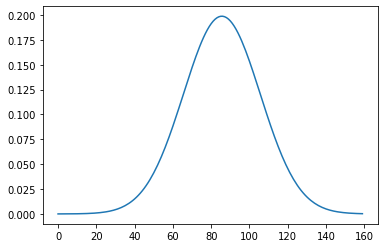

In [345]:
pd.Series(hmm.distribution.pdf(np.arange(-8,8,0.1))).plot()

In [302]:
hmm.iterate(1)

array([[2.9762760e-08, 9.9999997e-01]])

In [209]:
sample_1 = pd.DataFrame(sp.stats.multivariate_normal(mean=[1.1, 1.1], cov=[[0.2, 0.1],[0.1, 0.2]]).rvs(10000))

In [210]:
sample_1.corr()

,0,1
0,1.00000,0.49934
1,0.49934,1.00000


In [211]:
sample_1.cov()

,0,1
0,0.198820,0.099823
1,0.099823,0.201007


In [212]:
l = 20
_ = pd.DataFrame(sp.stats.multivariate_normal(mean=[1.1, 1.1], cov=[[0.2, 0.1],[0.1, 0.2]]).rvs(10000*l))
sample_2 = _.groupby(_.index // l).prod()

In [213]:
sample_2.corr()

,0,1
0,1.00000,0.18994
1,0.18994,1.00000


In [214]:
sample_2.cov()

,0,1
0,744.851879,152.137269
1,152.137269,861.331488
